In [ ]:
import sys
sys.path.append("..")

from models.taylorf2 import taylorf2
import jax.numpy as jnp
from jax import grad, config
import jax
import matplotlib.pyplot as plt
import os 
import numpy as np
config.update("jax_enable_x64", True)
import corner

from src.samplers import samplers
from scripts.plot_helper_functions import collect_samples


In [ ]:
# Define injection parameters
# injection = jnp.array([0, 0, 30.0, 0.24, 5e-22]) # For Stein
# injection = jnp.array([0, 0, 30.0, 0.24, 2e-22]) # For gradient testing
injection = jnp.array([0, 0, 30.0, 0.24, 0.05]) # For gradient testing

# Define prior ranges
priorDict = {}
priorDict[0] = injection[0] + jnp.array([-0.01, 0.01])
priorDict[1] = jnp.array([-jnp.pi, jnp.pi])
priorDict[2] = jnp.array([20., 40.])
# priorDict[3] = jnp.array([0.1, 0.249])
priorDict[3] = jnp.array([0.2, 0.249])
priorDict[4] = jnp.array([0.02, 0.07])

model = taylorf2(injection, priorDict)


In [ ]:
# Confirm that analytical derivative agrees with JAX derivative

x = model.injection + np.random.uniform(low=0, high=0.0001, size=5)

test1 = jax.jacfwd(model.potential_single)(x)
test2 = model.gradient_potential_single(x)

# These disagree?
print(test1)
print(test2)

test3 = jax.jacfwd(model.strain)(x,10)
test4 = model.gradient_strain(x, 10)

# These agree
print(test3)
print(test4)

In [ ]:
# import numdifftools as nd 

# This yields overflow ever
# nd.Gradient(model.potential_single)(x)

# These yield different result............ WTF
print(jax.jacrev(model.potential_single)(x))
print(model.gradient_potential_single(x))
print(jax.jacfwd(model.potential_single)(x))

In [ ]:
def getCrossSection(index1, index2, func, ngrid, DoF=5):
    # a, b are the parameters for which we want the marginals:
    x = np.linspace(priorDict[index1][0], priorDict[index1][1], ngrid)
    y = np.linspace(priorDict[index2][0], priorDict[index2][1], ngrid)
    X, Y = np.meshgrid(x, y)
    particle_grid = np.zeros((ngrid ** 2, DoF))
    parameter_mesh = np.vstack((np.ndarray.flatten(X), np.ndarray.flatten(Y))).T
    particle_grid[:, index1] = parameter_mesh[:, 0]
    particle_grid[:, index2] = parameter_mesh[:, 1]
    for i in range(DoF): # Fix all other parameters
        if i != index1 and i != index2:
            particle_grid[:, i] = np.ones(ngrid ** 2) * injection[i]
    Z = func(particle_grid).reshape(ngrid,ngrid)
    fig, ax = plt.subplots(figsize = (5, 5))
    cp = ax.contourf(X, Y, Z)
    plt.colorbar(cp)
    ax.set_xlabel(index1)
    ax.set_ylabel(index2)
    ax.set_title('Likelihood cross section')
    filename = str(index1) + str(index2) + '.png'
    path = os.path.join('marginals', filename)
    # fig.savefig(path)

posterior = lambda X: np.exp(-1 * model.getMinusLogPosterior_ensemble(X))

neg_potential = lambda X: -1 * model.getMinusLogPosterior_ensemble(X)

for i in range(5):
    for j in range(i+1, 5):
        # print('Getting cross section for %s' % pair)
        getCrossSection(i, j, posterior, 200)
        # getCrossSection(i, j, neg_potential, 200)

In [24]:
nParticles = 100
h = model.DoF / 10
nIterations = 5000
stride = 1000

bd_kwargs = {'use': True, 
             'kernel_type': 'Lp',
             'p':2,
             'h': 0.01,
             'start_iter': -1,
             'tau': 0.01,
             'space': 'primal',
             'stride': stride}

sampler1 = samplers(model=model, nIterations=nIterations, nParticles=nParticles, profile=False, kernel_type='Lp', bd_kwargs=bd_kwargs)
kernelKwargs = {'h':h, 'p':1, 'M': jnp.eye(5)} 

sampler1.apply(method='langevin', eps=0.0005, kernelKwargs=kernelKwargs)
# %%

buffer in prior: 0.000000


Stepsize 0.000500 | Median bandwidth: 2.999451 | n_events: 0: 100%|██████████| 5000/5000 [04:15<00:00, 19.53it/s]


In [ ]:
X1[-10000:,:].shape

In [ ]:
X1.shape

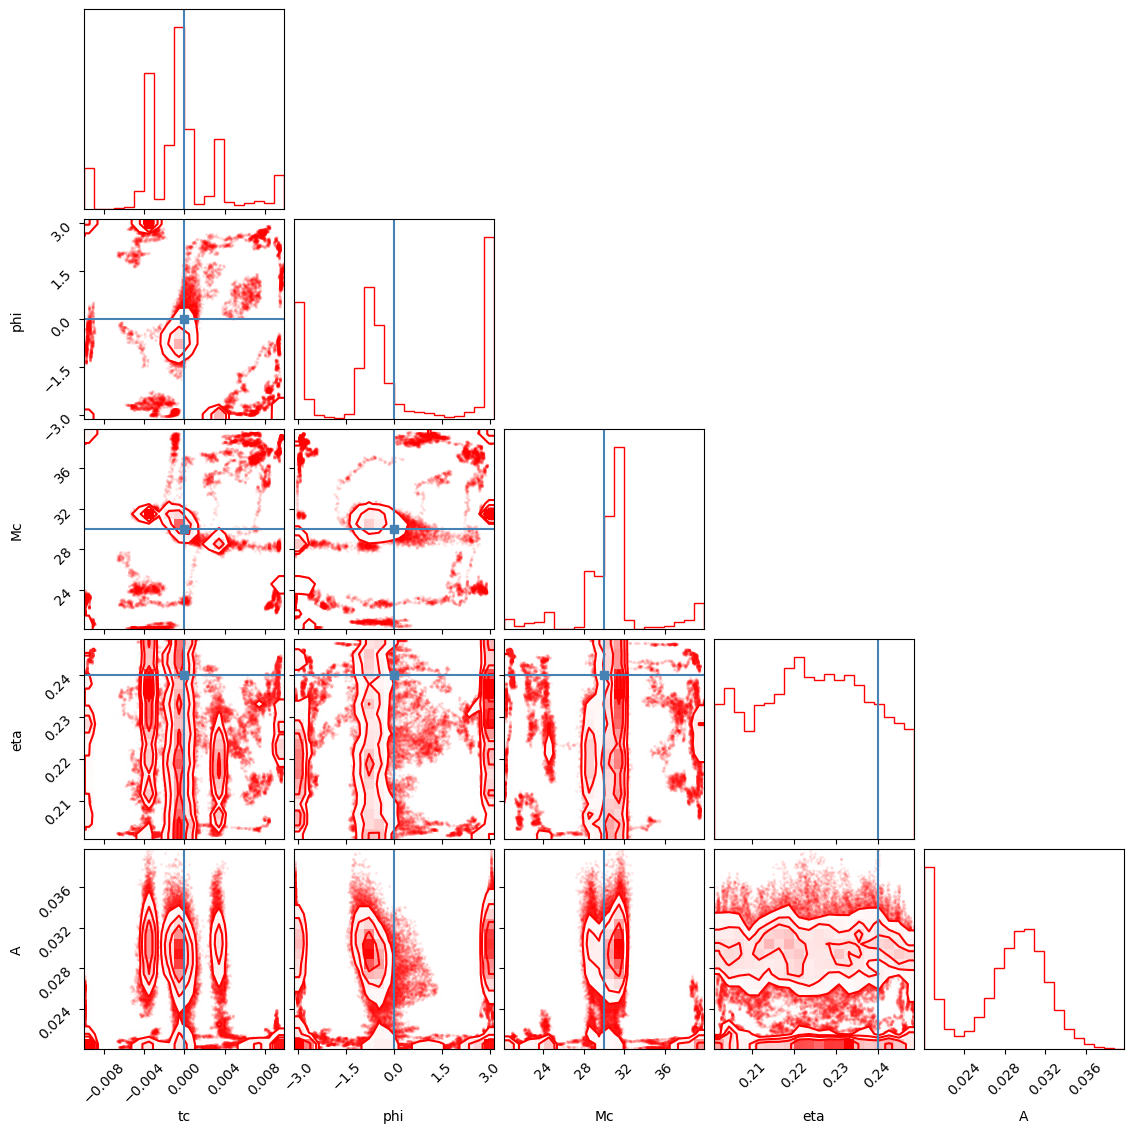

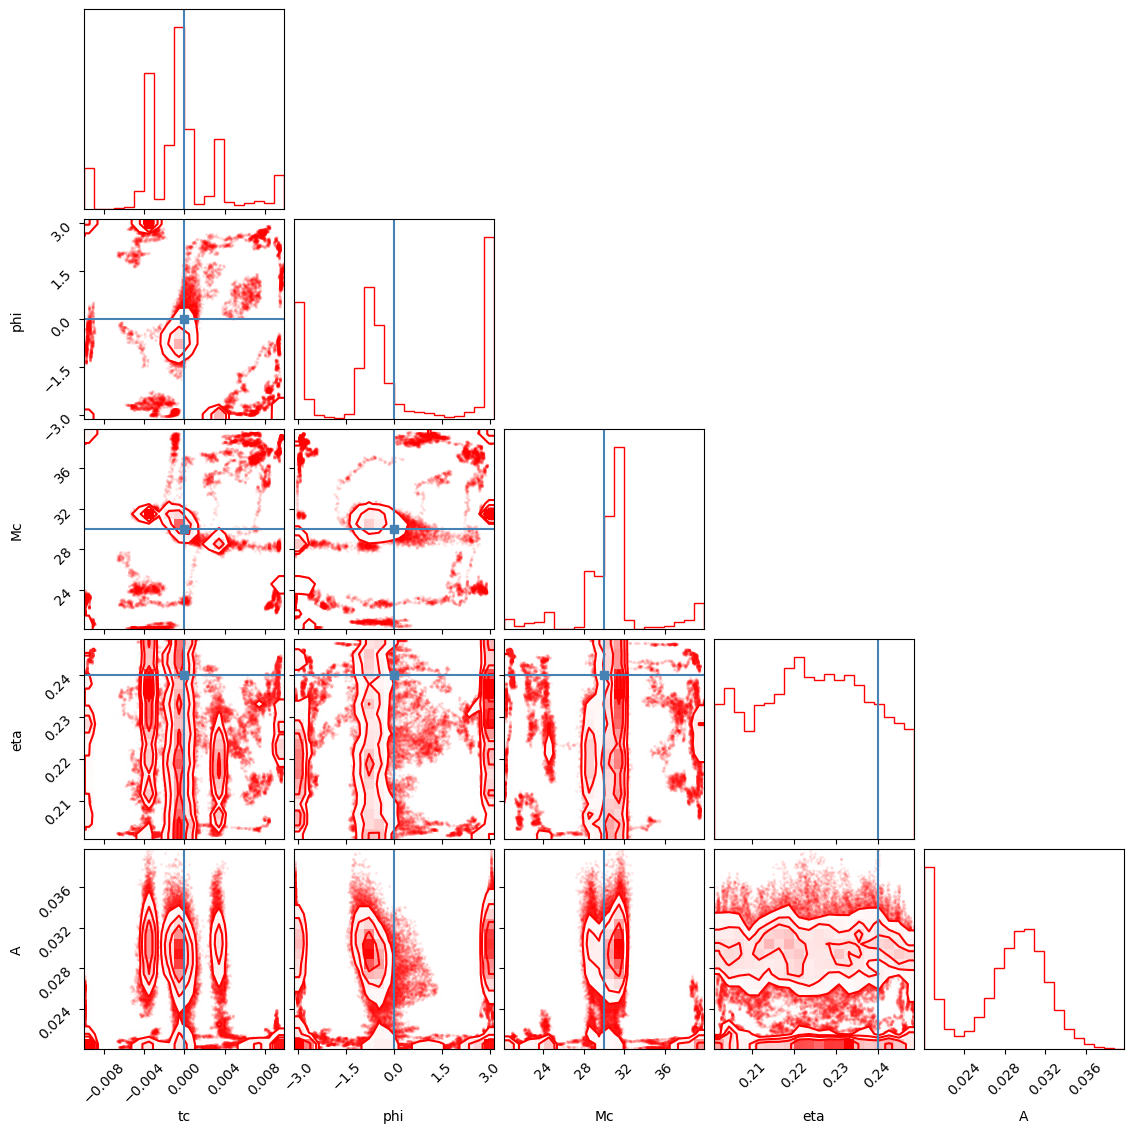

In [25]:
X1 = collect_samples(sampler1.history_path)
corner.corner(X1, color='r', labels=['tc', 'phi', 'Mc', 'eta', 'A'], truths=injection, hist_kwargs={'density':True})

In [ ]:
m_sun_sec

In [ ]:
x

In [ ]:
def strain(x, frequencies):
    time_coalescence = x[0]
    phase_coalescence = x[1]
    chirp_mass = x[2]
    symmetric_mass_ratio = x[3]
    Amplitude = x[4]
    m_sun_sec = 5e-6
    
    f = frequencies
    eta = symmetric_mass_ratio
    Mc = chirp_mass
    phi = phase_coalescence
    
    expr = (Amplitude * jnp.exp(-1j * (-(jnp.pi/4) + 2 * f * jnp.pi * time_coalescence + (
        3 * (1 + jnp.pi**(2/3) * ((f * Mc * m_sun_sec) / eta**(3/5))**(
            2/3) * (3715/756 + (55 * eta)/9))) / (
        128 * jnp.pi**(5/3) * ((f * Mc * m_sun_sec) / eta**(3/5))**(
            5/3) * eta) - phi))) / f**(7/6)
    
    return expr

def gradient_strain(x, frequencies):
    time_coalescence = x[0]
    phase_coalescence = x[1]
    chirp_mass = x[2]
    symmetric_mass_ratio = x[3]
    Amplitude = x[4]
    m_sun_sec = 5e-6
    
    f = frequencies
    eta = symmetric_mass_ratio
    Mc = chirp_mass
    S = strain(x, frequencies)
    
    expr1 = -2j * f * jnp.pi * S
    expr2 = 1j * S
    expr3 = (5j * S * (252 + jnp.pi**(2/3) * ((f * Mc * m_sun_sec) / eta**(3/5))**(
        2/3) * (743 + 924 * eta))) / (
        32256 * Mc * jnp.pi**(5/3) * ((f * Mc * m_sun_sec) / eta**(3/5))**(
            5/3) * eta)
    expr4 = -((1j * S * (-743 + 1386 * eta)) / (
        16128 * f * Mc * m_sun_sec * jnp.pi * eta**(7/5)))
    expr5 = S / Amplitude
    
    return jnp.array([expr1, expr2, expr3, expr4, expr5])

In [ ]:
time_coalescence = 1.0
phase_coalescence = 0.5
chirp_mass = 30.0
symmetric_mass_ratio = 0.25
amplitude = 2.0
frequency = jnp.linspace(10, 1000, 1)

x = np.array([time_coalescence, phase_coalescence, chirp_mass, symmetric_mass_ratio, amplitude])

print(strain(x, frequency))
print(gradient_strain(x, frequency))
print(jax.jacfwd(strain)(x,frequency))

In [ ]:
test1 = gradient_strain(x, frequency)
test2 = jax.jacfwd(strain)(x,frequency)
np.allclose(test1, test2.T) # Note: The outpout of JAX gives the opposite convention to that we are using

In [ ]:
test1.shape

In [ ]:
test2.shape